In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scipy
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.signal import find_peaks


In [2]:
def plotting(file,num,threshold):
    '''
    Funciton used to plot the data of the Raman Spectroscopy, it intakes the name of the .txt file and splits it
    in x and y axis data to plot. also the num input is to define whether the y-axis is scaled by log10 or not
    '''
    
    x,y = np.loadtxt(file, unpack = True)
    
    # Calculate z-scores
    #z_scores = zscore(y)
    
    # Create a mask for values within the z-score threshold
    #mask = np.abs(z_scores) < threshold

    # Filter data based on the mask
    #filtered_x = x[mask]
    #filtered_y = y[mask]
    
    
    gradient = np.gradient(y, x)
    x, y = np.array(x), np.array(y)
    mask = np.abs(gradient) < threshold
    fw = x[mask]
    fi = y[mask]

    # Create an interpolation function using linear interpolation
    interp_func = interp1d(fw, fi, kind='linear', fill_value='extrapolate')

    # Extrapolate missing values
    ex_y = interp_func(x)

    
    if 10 == num :
        
        plt.plot(x,np.log10(ex_y),)
        plt.xlabel("Raman shift cm$^{-1}$")
        plt.ylabel("Intensity (counts)")
        plt.title("Raman Spectroscopy of LFP at 5% laser intensity")
        plt.legend([file])
        plt.grid(True)
    elif 2 == num:
        plt.plot(x,(ex_y)/2)
        plt.xlabel("Raman shift cm$^{-1}$")
        plt.ylabel("Intensity (counts)")
        plt.title("Raman Spectroscopy of LFP at 5% laser intensity")   
        plt.legend([file])
        plt.grid(True)
    elif 5 == num:
        plt.plot(x,(ex_y)/5)
        plt.xlabel("Raman shift cm$^{-1}$")
        plt.ylabel("Intensity (counts)")
        plt.title("Raman Spectroscopy of LFP at 5% laser intensity")   
        plt.legend([file])
        plt.grid(True)
    else:
        plt.plot(x,ex_y,)
        plt.xlabel("Raman shift cm$^{-1}$")
        plt.ylabel("Intensity (counts)")
        plt.title("Raman Spectroscopy of LFP at 5% laser intensity")   
        plt.legend([file])
        plt.grid(True)
        
    print(ex_y)
    return

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class SpectraPlotter:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data_dict = self._read_data()

    def _read_data(self):
        data_dict = {}
        with open(self.file_path, 'r') as file:
            for line in file.readlines():
                x, y, wavenumber, intensity = map(float, line.split())
                coordinate = (x, y)
                if coordinate not in data_dict:
                    data_dict[coordinate] = []
                data_dict[coordinate].append((wavenumber, intensity))
        return data_dict

    def plot_single(self, coordinate, threshold):
        # Plot the data for a single coordinate
        if coordinate not in self.data_dict:
            print(f'No data found for coordinate {coordinate}')
            return

        wavenumbers, intensities = zip(*self.data_dict[coordinate])
        gradient = np.gradient(intensities, wavenumbers)
        wavenumbers, intensities = np.array(wavenumbers), np.array(intensities)
        mask = np.abs(gradient) < threshold
        fw = wavenumbers[mask]
        fi = intensities[mask]
        plt.plot(fw, fi, label=f'Coordinate {coordinate}')

        plt.xlabel('Wavenumber')
        plt.ylabel('Intensity')
        plt.title(f'Spectra for Coordinate {coordinate}')
        plt.grid()
        plt.legend()
        plt.show()

    def plot_more(self, target_x, threshold):
        # Plot the data for the specified x-coordinate
        for coordinate, spectra in self.data_dict.items():
            if coordinate[0] != target_x:
                continue  # Skip coordinates with different x

            wavenumbers, intensities = zip(*spectra)
            gradient = np.gradient(intensities, wavenumbers)
            wavenumbers, intensities = np.array(wavenumbers), np.array(intensities)
            mask = np.abs(gradient) < threshold
            fw = wavenumbers[mask]
            fi = intensities[mask]
            plt.plot(fw, fi, label=f'Coordinate {coordinate}')

        plt.xlabel('Wavenumber')
        plt.ylabel('Intensity')
        plt.title(f'Spectra for x-coordinate {target_x}')
        plt.grid()
        plt.legend()
        plt.show()



    def plot_file(self, threshold,logarithmic=False):
         #Plot the data from the initialized file
        wavenumbers, intensities = self.data[:, 2], self.data[:, 3]
        gradient = np.gradient(intensities, wavenumbers)
        mask = np.abs(gradient) < threshold
        fw = wavenumbers[mask]
        fi = intensities[mask]

        plt.figure()
        if logarithmic:
            plt.semilogy(fw, fi, label='All Coordinates (Log Scale)')
        else:
            plt.plot(fw, fi, label='All Coordinates')

        plt.xlabel('Wavenumber')
        plt.ylabel('Intensity')
        plt.title('Spectra for All Coordinates')
        plt.legend()
        plt.show()
        
    def plot_data_without_outliers(self, target_coordinates, lof_threshold):
        # Plot the data for desired coordinates without outliers
        for coordinate, spectra in self.data_dict.items():
            if coordinate not in target_coordinates:
                continue  # Skip coordinates that are not in the target list

            wavenumbers, intensities = zip(*spectra)
            X = np.column_stack((wavenumbers, intensities))

            # Calculate LOF scores
            lof_scores = self._calculate_lof(X)

            # Filter out points with higher LOF scores (lower density)
            filtered_indices = lof_scores < lof_threshold
            filtered_wavenumbers, filtered_intensities = np.array(wavenumbers)[filtered_indices], np.array(intensities)[filtered_indices]

            # Plot the data without outliers for the specific coordinate
            plt.scatter(filtered_wavenumbers, filtered_intensities, label=f'Data without Outliers for {coordinate}')

        plt.xlabel('Wavenumber')
        plt.ylabel('Intensity')
        plt.title('Data without Outliers for Desired Coordinates')
        plt.legend()
        plt.show()

    def _calculate_lof(self, X):
        from sklearn.neighbors import LocalOutlierFactor
        lof = LocalOutlierFactor(n_neighbors=20)  # Adjust n_neighbors parameter
        lof_scores = -lof.fit_predict(X)
        return lof_scores

# Example usage:
spectra_plotter = SpectraPlotter('map GR FePO4.txt')
spectra_plotter.plot_more(0, 100000000)
spectra_plotter.plot_more(10, 1500000000)
spectra_plotter.plot_more(20, 1500000000)
#spectra_plotter.plot_more(30, 150)
#spectra_plotter.plot_more(40, 150)
#spectra_plotter.plot_more(50, 150)

#spectra_plotter.plot_single((50,10),130)
#spectra_plotter.plot_single((40,10),130)
#plt.xlim(750,900)
#spectra_plotter.plot_single((50,30),130)
#plt.xlim(750,800)
#spectra_plotter.plot_single((30,50),150)


FileNotFoundError: [Errno 2] No such file or directory: 'map GR FePO4.txt'

[2161.04  2129.52  2023.12  ...  831.691  762.791  616.323]
[16400.   16692.1  16705.2  ...  4462.57  3780.92  3403.29]


Text(0.5, 1.0, '')

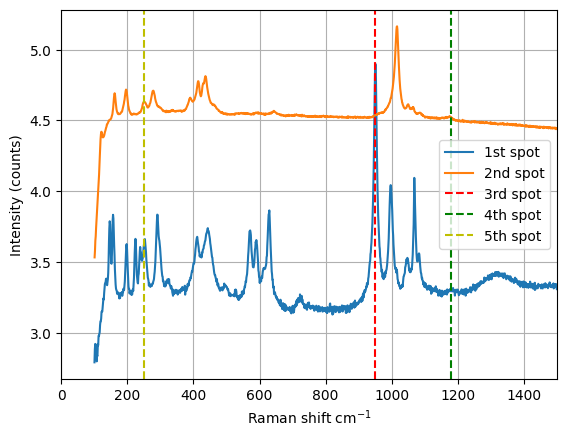

In [30]:
g= plotting('LFP spot 2.txt',10,30000)
g= plotting('10acc 1st GR FePO4-Copy1.txt',10,30000)
plt.xlim(0,1500)
#g= plotting('LFP spot 4.txt',10,30000)
#g= plotting('LFP spot 5.txt',10,30000)
#g= plotting('LFP spot 6.txt',10,30000)
#g= plotting('LFP spot 7.txt',10,30000)


plt.axvline(x=950, color='r', linestyle='--')
plt.axvline(x=1180, color='g', linestyle='--')
plt.axvline(x=250, color='y', linestyle='--')
plt.legend(["1st spot", "2nd spot", "3rd spot", "4th spot", "5th spot"])
plt.title("")

[2161.04  2129.52  2023.12  ...  831.691  762.791  616.323]
[5999.06       6055.2        6111.34       ... 1803.63081297 1553.77125811
 1303.69      ]


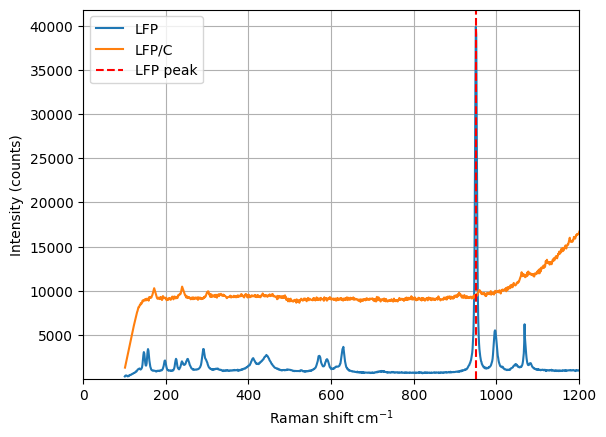

In [35]:
g= plotting('LFP spot 2.txt',2,30000)
h = plotting('white side working 4.2V.txt',0,130)
#g= plotting('LFP 1%int 1st run.txt',10,30000)
plt.axvline(x=950, color='r', linestyle='--')
plt.title("")
plt.xlim(0,1200)
plt.ylim(3,)
plt.legend(["LFP","LFP/C","LFP peak"])